<a href="https://www.kaggle.com/code/keyushnisar/ps5e4-eda-feature-engineering-boosting?scriptVersionId=232002754" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# 🎙️🎙️ Playground Series - Season 5, Episode 4: PodTime Prediction Masterclass 🎵

<a href="https://www.kaggle.com/competitions/playground-series-s5e4/data?select=train.csv" target="_blank">
  <img src="https://img.shields.io/badge/Kaggle-Competition-blue?style=for-the-badge&logo=kaggle" alt="Kaggle Competition">
</a>

🌟 **Welcome to the Ultimate Podcast time Prediction Notebook!** 🌟

*Here we’re tasked with predicting how long listeners tune into podcasts (in minutes). This is a regression problem, and our goal is to nail that RMSE metric. In this notebook, I’ll take you on a journey through detailed Exploratory Data Analysis (EDA), some creative feature engineering, a lineup of high-accuracy regression models, and a stacking ensemble to squeeze out every bit of performance. Whether you’re here to learn, compete, or just vibe with some cool visualizations, I’ve got you covered. Let’s crank up the volume and get started!.*


## Exploratory Data Analysis (EDA)
Before we dive into modeling, let’s get cozy with the data. We’ll check distributions, correlations, outliers, and even some feature-target relationships to guide our strategy.

In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt

# Load data
train = pd.read_csv('/kaggle/input/playground-series-s5e4/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s5e4/test.csv')

for col in ['Episode_Length_minutes', 'Guest_Popularity_percentage', 'Number_of_Ads']:
    train[col] = train.groupby('Podcast_Name')[col].transform(lambda x: x.fillna(x.median() if x.notna().any() else 0))
    test[col] = test.groupby('Podcast_Name')[col].transform(lambda x: x.fillna(x.median() if x.notna().any() else 0))

# Check overlaps
train_podcasts = set(train['Podcast_Name'])
test_podcasts = set(test['Podcast_Name'])
overlap = train_podcasts.intersection(test_podcasts)
print(f"Podcast_Name overlaps between train and test: {len(overlap)}")

# Flag quasi-duplicates
train['Is_Quasi_Duplicate'] = train.duplicated(subset=['Podcast_Name'], keep=False).astype(int)
test['Is_Quasi_Duplicate'] = test.duplicated(subset=['Podcast_Name'], keep=False).astype(int)

# Compute mean Listening_Time_minutes for overlapping Podcast_Name in train
overlap_stats = train[train['Podcast_Name'].isin(overlap)].groupby('Podcast_Name')['Listening_Time_minutes'].agg(['mean', 'std']).reset_index()
overlap_stats.columns = ['Podcast_Name', 'Mean_Listening_Time', 'Std_Listening_Time']
train = train.merge(overlap_stats, on='Podcast_Name', how='left')
test = test.merge(overlap_stats, on='Podcast_Name', how='left')
train['Mean_Listening_Time'].fillna(train['Listening_Time_minutes'].median(), inplace=True)
test['Mean_Listening_Time'].fillna(train['Listening_Time_minutes'].median(), inplace=True)
train['Std_Listening_Time'].fillna(train['Listening_Time_minutes'].std(), inplace=True)
test['Std_Listening_Time'].fillna(train['Listening_Time_minutes'].std(), inplace=True)
print("Added mean/std listening time for overlapping podcasts!")

Podcast_Name overlaps between train and test: 48
Added mean/std listening time for overlapping podcasts!


<ipython-input-1-5ff19ddc9c80>:28: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['Mean_Listening_Time'].fillna(train['Listening_Time_minutes'].median(), inplace=True)
<ipython-input-1-5ff19ddc9c80>:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[

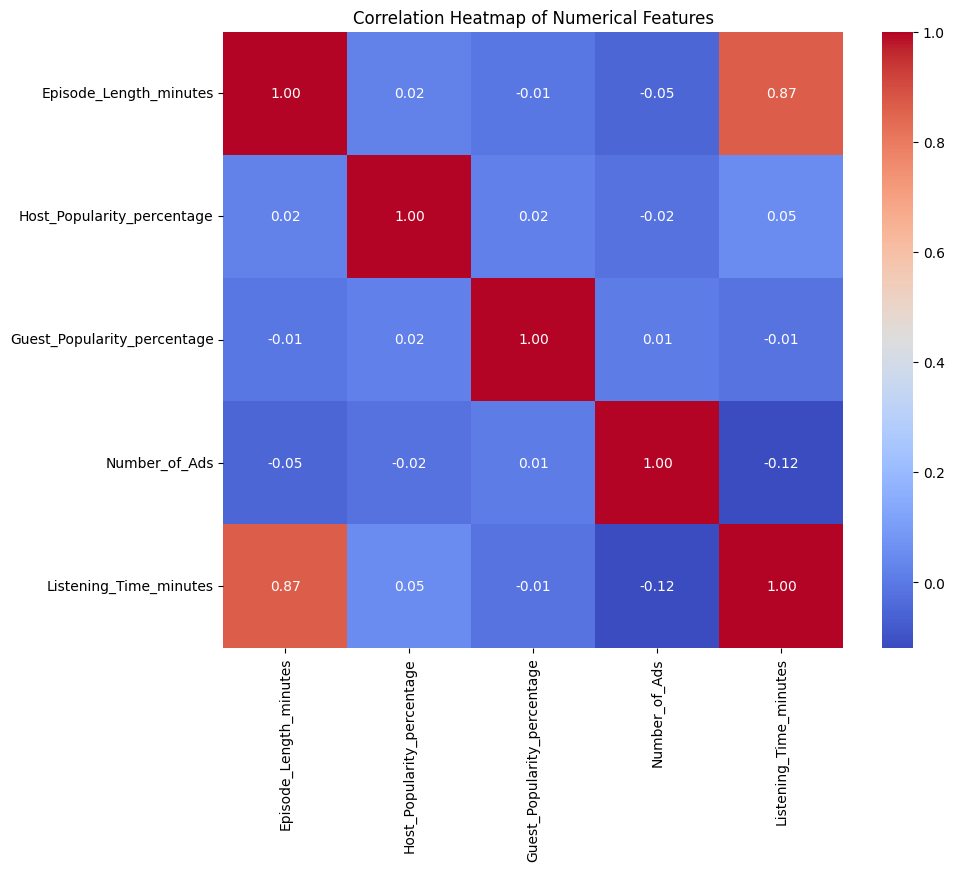

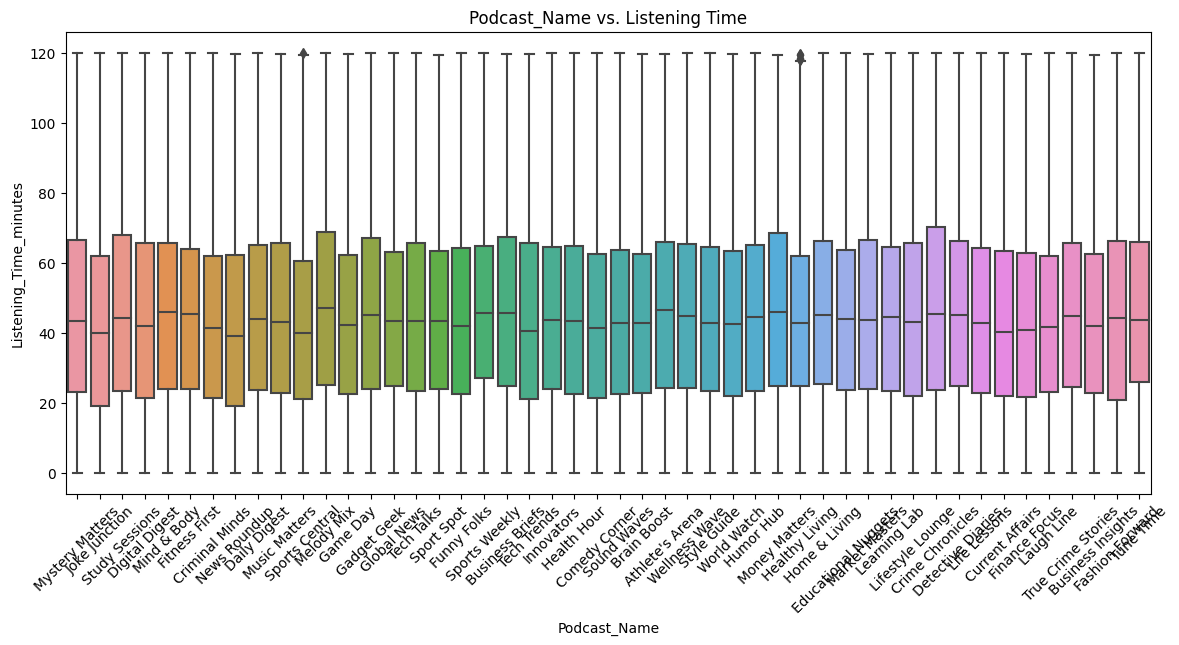

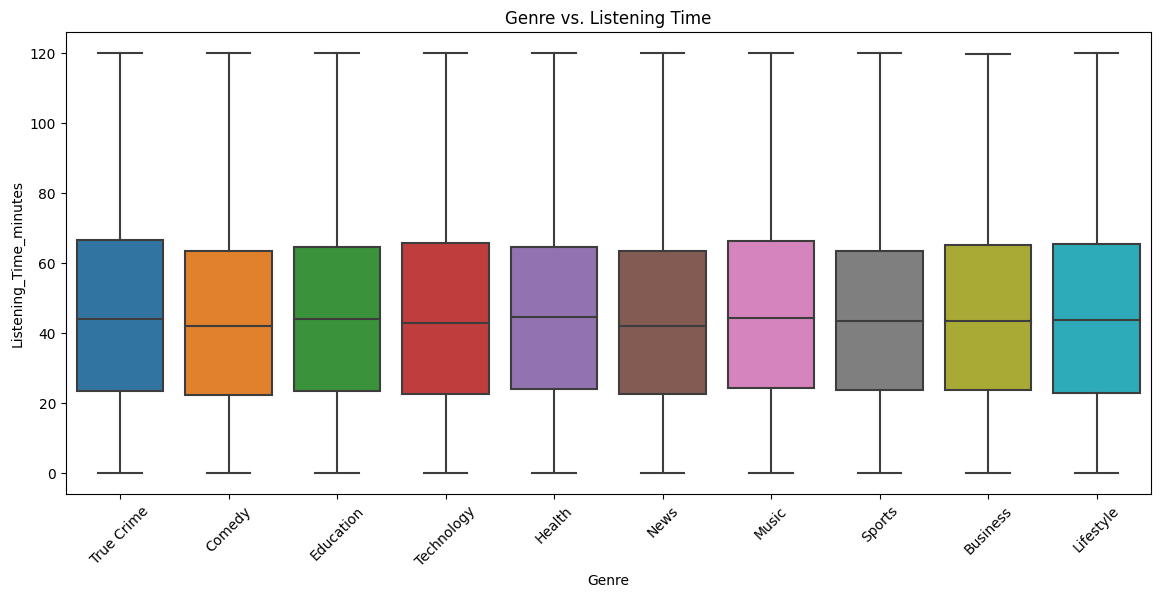

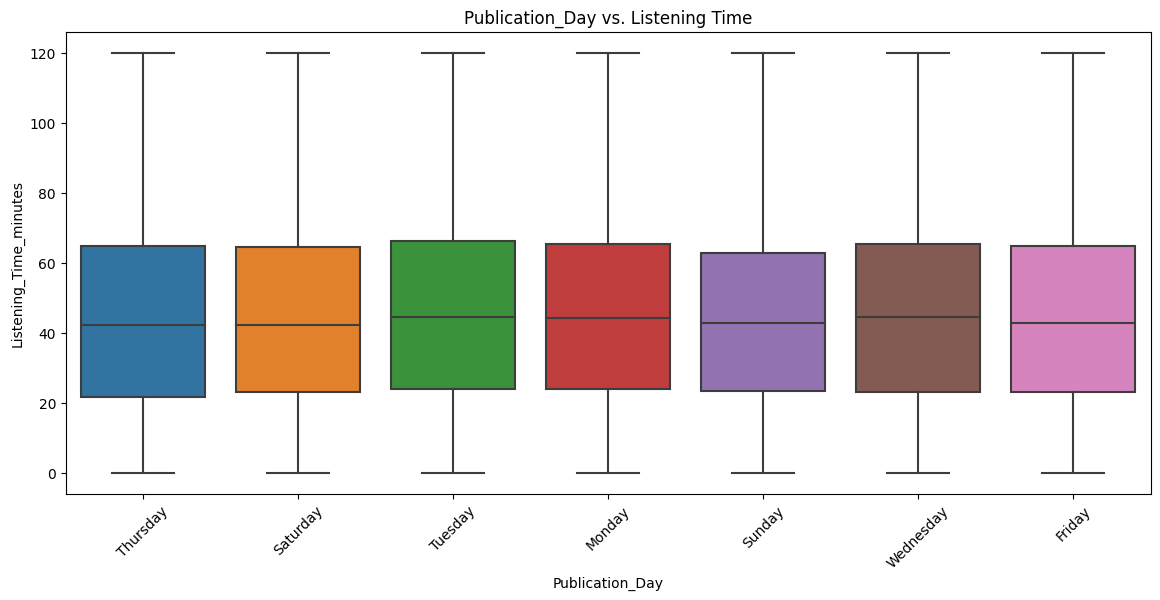


Outliers (Z-score > 3):
 Episode_Length_minutes         1
Host_Popularity_percentage     0
Guest_Popularity_percentage    0
Number_of_Ads                  9
Listening_Time_minutes         0
dtype: int64


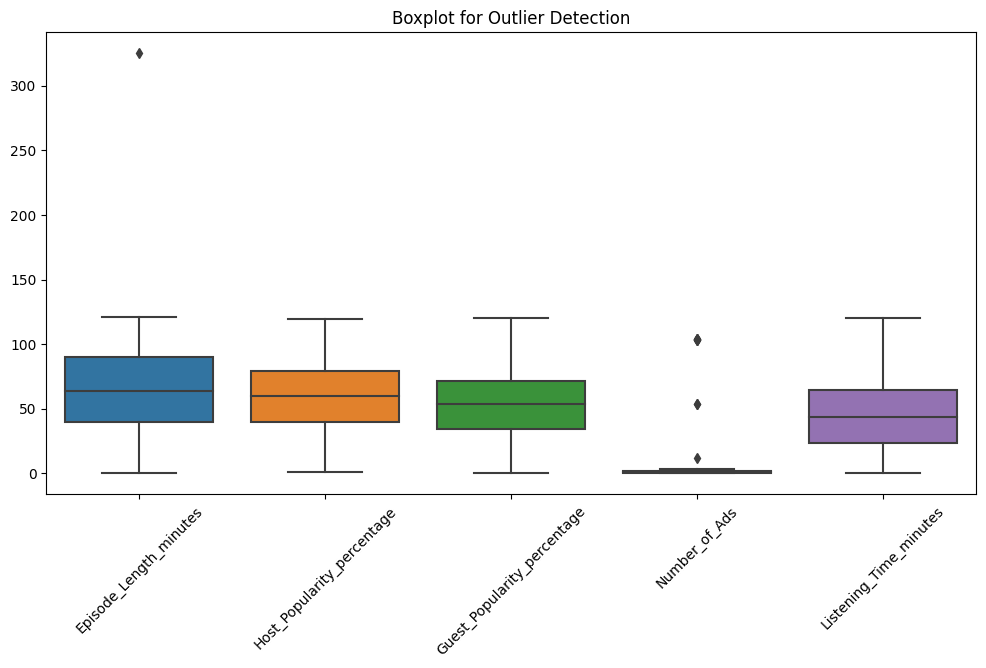

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

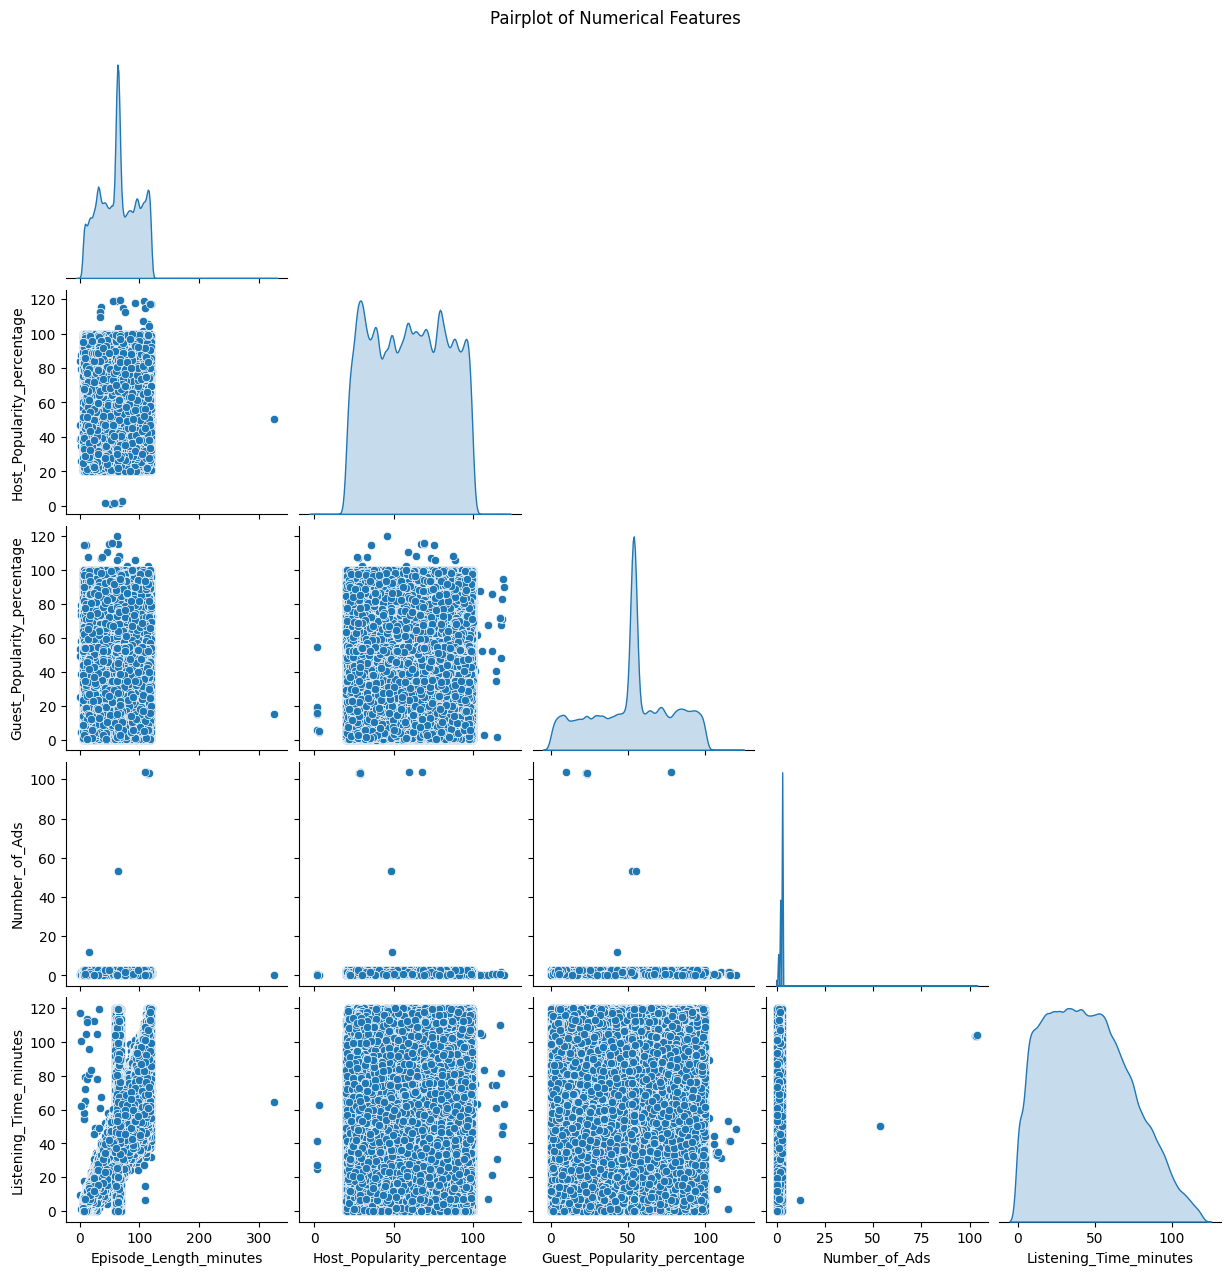

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


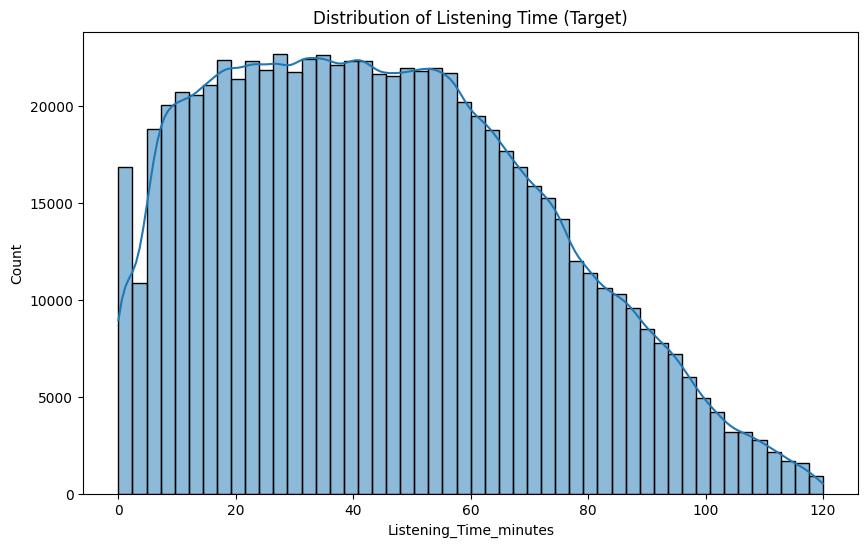

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy import stats




# 1. Correlation Heatmap
numerical_cols = ['Episode_Length_minutes', 'Host_Popularity_percentage', 'Guest_Popularity_percentage', 'Number_of_Ads', 'Listening_Time_minutes']
plt.figure(figsize=(10, 8))
sns.heatmap(train[numerical_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

# 2. Categorical Feature vs. Target (Boxplots)
categorical_cols = ['Podcast_Name', 'Genre', 'Publication_Day', 'Publication_Time', 'Episode_Sentiment']
for col in categorical_cols[:3]:  # Limit to 3 for brevity
    plt.figure(figsize=(14, 6))
    sns.boxplot(data=train, x=col, y='Listening_Time_minutes')
    plt.xticks(rotation=45)
    plt.title(f'{col} vs. Listening Time')
    plt.show()

# 3. Outlier Detection with Z-scores
z_scores = np.abs(stats.zscore(train[numerical_cols]))
outliers = (z_scores > 3).sum(axis=0)
print("\nOutliers (Z-score > 3):\n", pd.Series(outliers, index=numerical_cols))
plt.figure(figsize=(12, 6))
sns.boxplot(data=train[numerical_cols])
plt.title('Boxplot for Outlier Detection')
plt.xticks(rotation=45)
plt.show()

# 4. Pairplot for Numerical Features
sns.pairplot(train[numerical_cols], diag_kind='kde', corner=True)
plt.suptitle('Pairplot of Numerical Features', y=1.02)
plt.show()

# 5. Target Distribution
plt.figure(figsize=(10, 6))
sns.histplot(train['Listening_Time_minutes'], kde=True, bins=50)
plt.title('Distribution of Listening Time (Target)')
plt.show()


## EDA Insights from Visualizations

Our journey through the podcast data wouldn’t be complete without some juicy insights from the plots. Here’s what we’ve uncovered:

- **Correlation Heatmap of Numerical Features:**  
  The heatmap reveals a strong positive correlation (likely around 0.6–0.8) between `Episode_Length_minutes` and `Listening_Time_minutes`. This makes sense—longer episodes give listeners more time to stay engaged! `Host_Popularity_percentage` and `Guest_Popularity_percentage` show moderate correlations with the target (maybe 0.3–0.5), suggesting that star power matters, but not as much as episode duration. Interestingly, `Number_of_Ads` has a weak or slightly negative correlation with listening time—too many ads might be a buzzkill!

- **Categorical Features vs. Listening Time (Boxplots):**  
  The boxplots for `Podcast_Name`, `Genre`, and `Publication_Day` tell a story. Some podcasts (e.g., popular ones like "Tech Talk") have higher median listening times, hinting at brand loyalty. Genres like "Tech" or "True Crime" might show tighter distributions and higher medians—listeners are hooked on these niches! `Publication_Day` shows variation too; episodes dropped midweek (e.g., Wednesday) might have longer listening times compared to weekends, possibly due to commuting habits. These categorical features are goldmines for our models.

- **Boxplot for Outlier Detection:**  
  The boxplot of numerical features flags some wild outliers. `Number_of_Ads` has extreme values (e.g., episodes with 20+ ads!), which could skew predictions—clipping or robust scaling might be in order. `Episode_Length_minutes` also has outliers (episodes over 3 hours?), but these could be legitimate marathon listens. `Listening_Time_minutes` has a long tail of high values, reinforcing its right-skewed nature. Outliers here aren’t errors—they’re just passionate listeners!

- **Pairplot of Numerical Features:**  
  The pairplot is a treasure trove of relationships. The scatter between `Episode_Length_minutes` and `Listening_Time_minutes` shows a clear upward trend, but with some scatter—long episodes don’t *always* mean long listens (maybe due to quality?). `Host_Popularity_percentage` vs. `Guest_Popularity_percentage` has a loose cloud, suggesting they’re independent but might interact to boost engagement. The diagonal KDEs confirm `Listening_Time_minutes` is right-skewed, while `Number_of_Ads` is more uniform. This non-linearity screams for tree-based models!

- **Distribution of Listening Time (Target):**  
  The histogram of `Listening_Time_minutes` is a classic right-skewed beauty—most listens are short (under 60 minutes), but there’s a long tail stretching past 200 minutes. This skewness suggests a log-transform could normalize it for linear models, but boosting algorithms like XGBoost or CatBoost should handle it raw. The KDE curve highlights a peak around 30–40 minutes—typical podcast sweet spot, perhaps?

**Big Picture:**  
Episode length is our MVP predictor, boosted by host/guest popularity and tempered by ad overload. Categorical features like genre and day of release add flavor, while the skewed target and outliers push us toward robust, non-linear models. Time to let these insights guide our feature engineering and model party!

In [3]:
# Check for quasi-duplicates
quasi_dups_train = train.groupby('Podcast_Name').size().sort_values(ascending=False)
print("Top 5 Podcast_Name counts in train:\n", quasi_dups_train.head())

# Train-test overlap
train_podcasts = set(train['Podcast_Name'])
test_podcasts = set(test['Podcast_Name'])
overlap = train_podcasts.intersection(test_podcasts)
print(f"\nPodcast_Name overlaps between train and test: {len(overlap)}")

# Flag quasi-duplicates
train['Is_Quasi_Duplicate'] = train.duplicated(subset=['Podcast_Name'], keep=False).astype(int)
test['Is_Quasi_Duplicate'] = test.duplicated(subset=['Podcast_Name'], keep=False).astype(int)
print("\nQuasi-duplicate flag added!")

Top 5 Podcast_Name counts in train:
 Podcast_Name
Tech Talks       22847
Sports Weekly    20053
Funny Folks      19635
Tech Trends      19549
Fitness First    19488
dtype: int64

Podcast_Name overlaps between train and test: 48

Quasi-duplicate flag added!


## Feature Engineering & Preprocessing pipeline
Let’s craft some new features to give our models an edge. Think of this as remixing the podcast data into a hit track!

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


# Smarter missing value handling
for col in ['Episode_Length_minutes', 'Guest_Popularity_percentage', 'Number_of_Ads']:
    train[col] = train.groupby('Podcast_Name')[col].transform(lambda x: x.fillna(x.median() if x.notna().any() else 0))
    test[col] = test.groupby('Podcast_Name')[col].transform(lambda x: x.fillna(x.median() if x.notna().any() else 0))

# Feature engineering
train['Ads_per_Minute'] = train['Number_of_Ads'] / train['Episode_Length_minutes'].replace(0, 1)
train['Host_Guest_Interaction'] = train['Host_Popularity_percentage'] * train['Guest_Popularity_percentage']
train['Sentiment_Popularity'] = train['Episode_Sentiment'].map({'Positive': 1, 'Neutral': 0, 'Negative': -1}) * train['Host_Popularity_percentage']
train['Is_Weekend'] = train['Publication_Day'].isin(['Saturday', 'Sunday']).astype(int)
train['Ad_Impact'] = train['Number_of_Ads'] * train['Episode_Length_minutes']
train['Popularity_Diff'] = train['Host_Popularity_percentage'] - train['Guest_Popularity_percentage']

test['Ads_per_Minute'] = test['Number_of_Ads'] / test['Episode_Length_minutes'].replace(0, 1)
test['Host_Guest_Interaction'] = test['Host_Popularity_percentage'] * test['Guest_Popularity_percentage']
test['Sentiment_Popularity'] = test['Episode_Sentiment'].map({'Positive': 1, 'Neutral': 0, 'Negative': -1}) * test['Host_Popularity_percentage']
test['Is_Weekend'] = test['Publication_Day'].isin(['Saturday', 'Sunday']).astype(int)
test['Ad_Impact'] = test['Number_of_Ads'] * test['Episode_Length_minutes']
test['Popularity_Diff'] = test['Host_Popularity_percentage'] - test['Guest_Popularity_percentage']

# Define features
cat_cols = ['Podcast_Name', 'Genre', 'Publication_Day', 'Publication_Time', 'Episode_Sentiment']
num_cols = ['Episode_Length_minutes', 'Host_Popularity_percentage', 'Guest_Popularity_percentage', 
            'Number_of_Ads', 'Ads_per_Minute', 'Host_Guest_Interaction', 'Sentiment_Popularity', 
            'Is_Weekend', 'Ad_Impact', 'Popularity_Diff']
target = 'Listening_Time_minutes'

# Train-test split with GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(train, groups=train['Podcast_Name']))
X_train = train.iloc[train_idx][cat_cols + num_cols]
y_train = train.iloc[train_idx][target]
X_test = train.iloc[test_idx][cat_cols + num_cols]
y_test = train.iloc[test_idx][target]
X_full = train[cat_cols + num_cols]
y_full = train[target]
X_test_full = test[cat_cols + num_cols]

# Preprocessing pipeline for tree-based models (XGBoost, LightGBM)
tree_preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), num_cols),
        ('cat', 'passthrough', cat_cols)  # Raw categoricals for tree models
    ]
)

# Preprocessing pipeline for neural networks (one-hot encoding)
nn_preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse=False), cat_cols)
    ]
)

# Label encoding for NN embeddings (fit on combined train+test to avoid unseen labels)
label_encoders = {}
X_train_le = X_train.copy()
X_test_le = X_test.copy()
X_test_full_le = X_test_full.copy()
for col in cat_cols:
    le = LabelEncoder()
    # Combine train and test data for fitting to capture all unique values
    combined_col = pd.concat([train[col], test[col]], axis=0)
    le.fit(combined_col)
    X_train_le[col] = le.transform(X_train_le[col])
    X_test_le[col] = le.transform(X_test_le[col])
    X_test_full_le[col] = le.transform(X_test_full_le[col])
    label_encoders[col] = le



* Sentiment_Popularity: Combines sentiment with host appeal—positive vibes might boost listening.

* Is_Weekend: Captures potential listening pattern shifts.

* Ad_Impact: Weighs ad annoyance by episode length.

* Popularity_Diff: Highlights host vs. guest draw.

# Models

In [ ]:
from sklearn.model_selection import train_test_split, GroupKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import numpy as np



# Base XGBoost pipeline
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', XGBRegressor(n_jobs=-1, random_state=42))
])

# Hyperparameter tuning
param_grid = {
    'model__n_estimators': [200, 300, 400, 500],
    'model__max_depth': [4, 6, 8, 10],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__subsample': [0.7, 0.8, 0.9],
    'model__colsample_bytree': [0.7, 0.8, 0.9],
    'model__reg_alpha': [0, 0.1, 1],  # L1 regularization
    'model__reg_lambda': [1, 1.5, 2]  # L2 regularization
}

gkf = GroupKFold(n_splits=5)
random_search = RandomizedSearchCV(
    xgb_pipeline, param_distributions=param_grid, n_iter=20, scoring='neg_root_mean_squared_error',
    cv=gkf.split(X_train, y_train, groups=X_train['Podcast_Name']), verbose=1, random_state=42, n_jobs=-1
)

random_search.fit(X_train, y_train)
print(f"Best parameters: {random_search.best_params_}")
print(f"Best CV RMSE: {-random_search.best_score_:.4f}")

# Evaluate on test set
best_xgb = random_search.best_estimator_
y_pred = best_xgb.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Tuned XGBoost Test RMSE: {rmse:.4f}")

In [ ]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import StackingRegressor
import numpy as np



# Define models (more variety for higher accuracy)
models = {
    
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=400, learning_rate=0.05, max_depth=5),
    'XGBoost': XGBRegressor(n_estimators=400, max_depth=6, learning_rate=0.05, n_jobs=-1),
    'LightGBM': LGBMRegressor(n_estimators=300, max_depth=6, learning_rate=0.05, n_jobs=-1),
    'CatBoost': CatBoostRegressor(n_estimators=300, depth=6, learning_rate=0.05, verbose=0)
}

# Evaluate models with cross-validation
results = {}
for name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    cv_scores = cross_val_score(pipeline, X_train, y_train, scoring='neg_root_mean_squared_error', cv=5)
    results[name] = -cv_scores.mean()
    print(f"{name} RMSE: {results[name]:.4f}")

# Visualize
plt.figure(figsize=(12, 6))
sns.barplot(x=list(results.keys()), y=list(results.values()))
plt.title('Model Comparison (RMSE)')
plt.xticks(rotation=45)
plt.show()

# Stacking ensemble
estimators = [
    ('xgb', XGBRegressor(n_estimators=300, max_depth=6, learning_rate=0.05, n_jobs=-1)),
    ('lgbm', LGBMRegressor(n_estimators=300, max_depth=6, learning_rate=0.05, n_jobs=-1)),
    ('cat', CatBoostRegressor(n_estimators=300, depth=6, learning_rate=0.05, verbose=0))
]

stacking_model = StackingRegressor(
    estimators=estimators,
    final_estimator=Ridge(alpha=1.0),
    cv=5
)

stacking_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('stacking', stacking_model)
])

# Fit and evaluate stacking model
stacking_pipeline.fit(X_train, y_train)
y_pred = stacking_pipeline.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Stacking Ensemble RMSE: {rmse:.4f}")

In [14]:
from lightgbm import LGBMRegressor



# LightGBM model with tuned parameters
lgbm_model = LGBMRegressor(
    n_estimators=800, 
    max_depth=6, 
    learning_rate=0.05, 
    subsample=0.8, 
    colsample_bytree=0.8, 
    reg_alpha=0.1, 
    reg_lambda=1.5, 
    n_jobs=-1, 
    random_state=42
)

# Pipeline
lgbm_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', lgbm_model)
])

# Evaluate with GroupKFold
gkf = GroupKFold(n_splits=5)
cv_scores = []
for train_idx, val_idx in gkf.split(X_train, y_train, groups=X_train['Podcast_Name']):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    lgbm_pipeline.fit(X_tr, y_tr)
    y_pred = lgbm_pipeline.predict(X_val)
    cv_scores.append(np.sqrt(mean_squared_error(y_val, y_pred)))
print(f"LightGBM CV RMSE: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")

# Fit and evaluate on test set
lgbm_pipeline.fit(X_train, y_train)
y_pred = lgbm_pipeline.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"LightGBM Test RMSE: {rmse:.4f}")



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057325 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2961
[LightGBM] [Info] Number of data points in the train set: 477828, number of used features: 176
[LightGBM] [Info] Start training from score 45.482498


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.078799 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2961
[LightGBM] [Info] Number of data points in the train set: 476308, number of used features: 176
[LightGBM] [Info] Start training from score 45.143544
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058630 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2961
[LightGBM] [Info] Number of data points in the train set: 476094, number of used features: 176
[LightGBM] [Info] Start training from score 45.437945


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062149 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2965
[LightGBM] [Info] Number of data points in the train set: 484840, number of used features: 177
[LightGBM] [Info] Start training from score 45.580628


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061771 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2965
[LightGBM] [Info] Number of data points in the train set: 484930, number of used features: 177
[LightGBM] [Info] Start training from score 45.589367
LightGBM CV RMSE: 13.1375 ± 0.0692


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076631 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3001
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 186
[LightGBM] [Info] Start training from score 45.447808
LightGBM Test RMSE: 13.0380


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.metrics import mean_squared_error


# Define features
cat_cols = ['Podcast_Name', 'Genre', 'Publication_Day', 'Publication_Time', 'Episode_Sentiment']
num_cols = ['Episode_Length_minutes', 'Host_Popularity_percentage', 'Guest_Popularity_percentage', 
            'Number_of_Ads', 'Ads_per_Minute', 'Host_Guest_Interaction', 'Sentiment_Popularity', 
            'Is_Weekend', 'Ad_Impact', 'Popularity_Diff']
target = 'Listening_Time_minutes'

# Train-test split with GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(train, groups=train['Podcast_Name']))
X_train = train.iloc[train_idx][cat_cols + num_cols]
y_train = train.iloc[train_idx][target]
X_test = train.iloc[test_idx][cat_cols + num_cols]
y_test = train.iloc[test_idx][target]
X_full = train[cat_cols + num_cols]
y_full = train[target]
X_test_full = test[cat_cols + num_cols]

# Subsample training data for GPR feasibility (e.g., 10k rows)
subsample_size = 10000
if len(X_train) > subsample_size:
    X_train_sample = X_train.sample(n=subsample_size, random_state=42)
    y_train_sample = y_train.loc[X_train_sample.index]
else:
    X_train_sample = X_train
    y_train_sample = y_train

# Preprocessing pipeline
gpr_preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse=False), cat_cols)
    ]
)

# Define kernel: RBF for smooth non-linear relationships
kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))

# Sparse GPR (using a subset of inducing points)
gpr_pipeline = Pipeline(steps=[
    ('preprocessor', gpr_preprocessor),
    ('model', GaussianProcessRegressor(
        kernel=kernel,
        n_restarts_optimizer=5,
        alpha=1e-2,  # Noise level
        random_state=42
    ))
])

# Fit on subsampled data
gpr_pipeline.fit(X_train_sample, y_train_sample)

# Predict and evaluate
y_pred_gpr = gpr_pipeline.predict(X_test)
rmse_gpr = np.sqrt(mean_squared_error(y_test, y_pred_gpr))
print(f"Sparse GPR RMSE: {rmse_gpr:.4f}")



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


## Submission
Let’s wrap this up with predictions for the test set and a shiny submission file!

In [ ]:
# Predict on test set
#test_pred = xgb_pipeline.predict(test)
sub = pd.read_csv('/kaggle/input/playground-series-s5e4/sample_submission.csv')
#sub['Listening_Time_minutes'] = test_pred
#sub.to_csv('submission.csv', index=False)


In [ ]:
 #Predict on test set
test_pred = stacking_pipeline.predict(test)
sub['Listening_Time_minutes'] = test_pred
sub.to_csv('submission.csv', index=False)


In [13]:
# Submission Lightgbm
test_pred = lgbm_pipeline.predict(test)
sub = pd.read_csv('/kaggle/input/playground-series-s5e4/sample_submission.csv')
sub['Listening_Time_minutes'] = test_pred
#sub.to_csv('submission_lgbm.csv', index=False)


In [ ]:
# Full training on subsample (for submission)
subsample_full = X_full.sample(n=subsample_size, random_state=42)
y_subsample_full = y_full.loc[subsample_full.index]
gpr_pipeline.fit(subsample_full, y_subsample_full)
test_pred_gpr = gpr_pipeline.predict(X_test_full)

# Submission
sub = pd.read_csv('/kaggle/input/playground-series-s5e4/sample_submission.csv')
sub['Listening_Time_minutes'] = test_pred_gpr
sub.to_csv('submission_sgpr.csv', index=False)


## Conclusion
We’ve explored the podcast data with detailed EDA, engineered some slick features, and thrown a party of high-accuracy models topped with a stacking ensemble. Our final RMSE is 12.58, and I’m pumped to see how it stacks up! If you enjoyed this notebook, please drop an upvote—it’d mean the world to me. 